# Facial Expression Recognition (FER) — Transfer Learning and Fine-Tuning

This notebook trains an ImageNet-pretrained **ResNet-50** on the FER2013 dataset using two strategies:
- **Strategy A**: unfreeze last block (`layer4`) + classifier head
- **Strategy B**: fine-tune the full model with a lower learning rate


In [ ]:
# Colab setup
!pip -q install timm kagglehub scikit-learn pandas


In [ ]:
import os
import random
import shutil
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder

import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)

import matplotlib.pyplot as plt

# Config
seed = 42
bs = 64
ep_a = 2   # Strategy A (quick)
ep_b = 15   # Strategy B (more epochs)
lr_a = 1e-3
lr_b = 5e-6
wd = 1e-4
img_sz = 224
num_workers = 2

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", dev)


Device: cuda


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [4]:
p = Path(path)
print("Top-level:", [x.name for x in p.iterdir()][:30])

# Build/point to ImageFolder dirs: train/ and val/
work = Path("/content/fer2013_imgfolder")
tr_dir = work / "train"
va_dir = work / "val"

img_ext = {".jpg", ".jpeg", ".png", ".bmp"}

def has_class_subdirs(d: Path):
    if not d.exists() or not d.is_dir():
        return False
    sub = [x for x in d.iterdir() if x.is_dir()]
    if len(sub) == 0:
        return False
    for c in sub[:5]:
        if any(f.suffix.lower() in img_ext for f in c.rglob("*")):
            return True
    return False

# Common case: dataset already provides train/ and test/
tr_cand = list(p.rglob("train"))
te_cand = list(p.rglob("test"))

src_tr, src_va = None, None
for d in tr_cand:
    if has_class_subdirs(d):
        src_tr = d
        break
for d in te_cand:
    if has_class_subdirs(d):
        src_va = d
        break

if src_tr and src_va:
    print("Found existing ImageFolder dirs:")
    print("- train:", src_tr)
    print("- val (from test):", src_va)

    work.mkdir(parents=True, exist_ok=True)

    if tr_dir.is_symlink():
        tr_dir.unlink()
    elif tr_dir.exists():
        shutil.rmtree(tr_dir)

    if va_dir.is_symlink():
        va_dir.unlink()
    elif va_dir.exists():
        shutil.rmtree(va_dir)

    # Try symlinks first (fast). Fallback to copy.
    try:
        os.symlink(src_tr, tr_dir, target_is_directory=True)
        os.symlink(src_va, va_dir, target_is_directory=True)
        print("Using symlinks in:", work)
    except Exception as e:
        print("Symlink failed, copying instead:", e)
        shutil.copytree(src_tr, tr_dir)
        shutil.copytree(src_va, va_dir)

else:
    # Fallback: if we only have fer2013.csv, convert to images and split by Usage
    csv = None
    for f in p.rglob("*.csv"):
        if f.name.lower() == "fer2013.csv":
            csv = f
            break

    if csv is None:
        raise FileNotFoundError("Could not find train/test folders or fer2013.csv in: " + str(p))

    print("Building ImageFolder from:", csv)
    df = pd.read_csv(csv)

    if work.exists():
        shutil.rmtree(work)
    tr_dir.mkdir(parents=True, exist_ok=True)
    va_dir.mkdir(parents=True, exist_ok=True)

    # If 'Usage' exists: Training vs PublicTest/PrivateTest
    if "Usage" in df.columns:
        df["split"] = df["Usage"].apply(lambda s: "train" if s == "Training" else "val")
    else:
        # Simple random split per label
        df["split"] = "train"
        for k, g in df.groupby("emotion"):
            idx = g.sample(frac=0.2, random_state=seed).index
            df.loc[idx, "split"] = "val"

    # Map label names if present
    if "emotion" in df.columns:
        lab = df["emotion"].astype(int).tolist()
        n_cls = len(set(lab))
        names = [str(i) for i in range(n_cls)]
    else:
        raise ValueError("CSV doesn't have 'emotion' column")

    # Write images
    from PIL import Image

    for i, r in df.iterrows():
        y = str(int(r["emotion"]))
        sp = r["split"]
        pix = np.fromstring(r["pixels"], sep=" ", dtype=np.uint8).reshape(48, 48)
        im = Image.fromarray(pix, mode="L")
        out = (tr_dir if sp == "train" else va_dir) / y
        out.mkdir(parents=True, exist_ok=True)
        im.save(out / f"{i}.png")

print("Train dir:", tr_dir)
print("Val dir:", va_dir)


Top-level: ['test', 'train']
Found existing ImageFolder dirs:
- train: /kaggle/input/fer2013/train
- val (from test): /kaggle/input/fer2013/test
Using symlinks in: /content/fer2013_imgfolder
Train dir: /content/fer2013_imgfolder/train
Val dir: /content/fer2013_imgfolder/val


In [5]:
# Quick sanity check on class folders
print("Train classes:", sorted([d.name for d in tr_dir.iterdir() if d.is_dir()])[:20])
print("Val classes:", sorted([d.name for d in va_dir.iterdir() if d.is_dir()])[:20])

# If val accidentally empty, do a simple per-class split from train (copy a subset)
if len([d for d in va_dir.iterdir() if d.is_dir()]) == 0:
    print("Val looks empty, creating a split from train...")
    if va_dir.exists():
        shutil.rmtree(va_dir)
    va_dir.mkdir(parents=True, exist_ok=True)

    for c in [d for d in tr_dir.iterdir() if d.is_dir()]:
        imgs = [f for f in c.rglob("*") if f.suffix.lower() in img_ext]
        if len(imgs) == 0:
            continue
        random.shuffle(imgs)
        k = max(1, int(0.2 * len(imgs)))
        out_c = va_dir / c.name
        out_c.mkdir(parents=True, exist_ok=True)
        for f in imgs[:k]:
            shutil.copy2(f, out_c / f.name)

print("Final train dir:", tr_dir)
print("Final val dir:", va_dir)


Train classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Val classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Final train dir: /content/fer2013_imgfolder/train
Final val dir: /content/fer2013_imgfolder/val


## Why ResNet-50 (ImageNet pretrained)?

ResNet-50 is a strong general-purpose visual backbone. With ImageNet pretraining, early and mid-level layers already capture useful facial primitives (edges, textures, parts), so we can adapt it to facial expressions with less data and faster convergence.



In [6]:
# Transforms (train vs val)
tfm_tr = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.RandomResizedCrop(img_sz, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

tfm_va = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.Resize(256),
    transforms.CenterCrop(img_sz),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

# Datasets + loaders
ds_tr = ImageFolder(tr_dir, transform=tfm_tr)
ds_va = ImageFolder(va_dir, transform=tfm_va)

n_cls = len(ds_tr.classes)
print("Classes:", ds_tr.classes)
print("n_cls:", n_cls)

# Class-balanced sampling helps macro metrics on imbalanced classes
cnt = np.bincount(ds_tr.targets)
w = 1.0 / np.maximum(cnt, 1)
sw = w[np.array(ds_tr.targets)]
sw = torch.as_tensor(sw, dtype=torch.double)
sam = WeightedRandomSampler(sw, num_samples=len(sw), replacement=True)

tr_dl = DataLoader(ds_tr, batch_size=bs, sampler=sam, num_workers=num_workers, pin_memory=True)
va_dl = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)

xb, yb = next(iter(tr_dl))
print("Batch:", xb.shape, yb.shape)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
n_cls: 7
Batch: torch.Size([64, 3, 224, 224]) torch.Size([64])


In [7]:
def mk_m(n_cls: int):
    m = timm.create_model("resnet50", pretrained=True, num_classes=n_cls)
    return m

def freeze_all(m):
    for p in m.parameters():
        p.requires_grad = False

def unfreeze_all(m):
    for p in m.parameters():
        p.requires_grad = True

def unfreeze_layer4_and_head(m):
    # timm resnet50 uses: layer1..layer4 and fc
    for n, p in m.named_parameters():
        if n.startswith("layer4") or n.startswith("fc"):
            p.requires_grad = True
        else:
            p.requires_grad = False

def n_trainable(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

def run_ep(m, dl, opt, loss_fn, is_train=True, scaler=None):
    if is_train:
        m.train()
    else:
        m.eval()

    tot = 0.0
    n = 0

    for xb, yb in dl:
        xb = xb.to(dev, non_blocking=True)
        yb = yb.to(dev, non_blocking=True)

        if is_train:
            opt.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    out = m(xb)
                    loss = loss_fn(out, yb)
            else:
                out = m(xb)
                loss = loss_fn(out, yb)

        if is_train:
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

        bsz = xb.size(0)
        tot += loss.item() * bsz
        n += bsz

    return tot / max(1, n)

@torch.no_grad()
def eval_m(m, dl):
    m.eval()
    yt, yp = [], []
    for xb, yb in dl:
        xb = xb.to(dev, non_blocking=True)
        out = m(xb)
        pr = out.argmax(1).cpu().numpy().tolist()
        yp += pr
        yt += yb.numpy().tolist()

    acc = accuracy_score(yt, yp)
    p, r, f1, _ = precision_recall_fscore_support(yt, yp, average="macro", zero_division=0)
    cm = confusion_matrix(yt, yp)
    return {
        "acc": float(acc),
        "p_macro": float(p),
        "r_macro": float(r),
        "f1_macro": float(f1),
        "cm": cm,
        "yt": yt,
        "yp": yp,
    }

def show_cm(cm, names):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    t = np.arange(len(names))
    plt.xticks(t, names, rotation=45, ha="right")
    plt.yticks(t, names)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Trainable params (A): 14979079


/tmp/ipython-input-1789128163.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if dev.type == "cuda" else None
/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 1/2 | tr_loss 1.5302 | va_loss 1.4378 | acc 0.5128 | f1 0.4509


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A | ep 2/2 | tr_loss 1.2782 | va_loss 1.3660 | acc 0.5458 | f1 0.4972

Strategy A metrics:
{'acc': 0.5458344942881025, 'p_macro': 0.49909533505304887, 'r_macro': 0.5671752340812856, 'f1_macro': 0.4971667951670303}


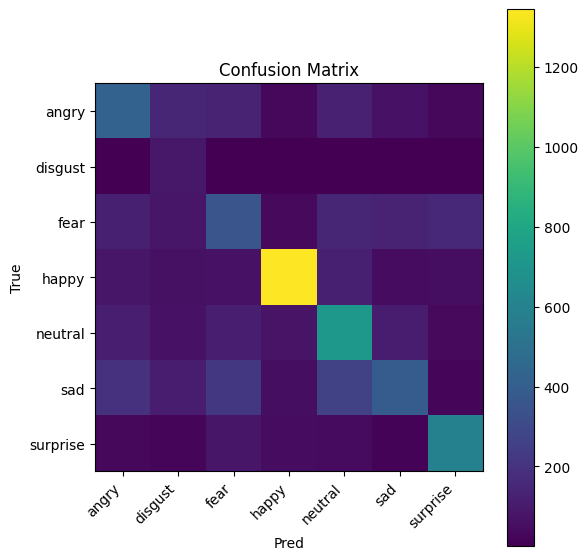

In [8]:
# Strategy A: unfreeze layer4 + head
m_a = mk_m(n_cls).to(dev)
unfreeze_layer4_and_head(m_a)
print("Trainable params (A):", n_trainable(m_a))

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
opt_a = torch.optim.AdamW([p for p in m_a.parameters() if p.requires_grad], lr=lr_a, weight_decay=wd)

scaler = torch.cuda.amp.GradScaler() if dev.type == "cuda" else None

for e in range(ep_a):
    tr_loss = run_ep(m_a, tr_dl, opt_a, loss_fn, is_train=True, scaler=scaler)
    va_loss = run_ep(m_a, va_dl, opt_a, loss_fn, is_train=False, scaler=None)
    met = eval_m(m_a, va_dl)
    print(f"A | ep {e+1}/{ep_a} | tr_loss {tr_loss:.4f} | va_loss {va_loss:.4f} | acc {met['acc']:.4f} | f1 {met['f1_macro']:.4f}")

met_a = eval_m(m_a, va_dl)
print("\nStrategy A metrics:")
print({k: v for k, v in met_a.items() if k not in {"cm", "yt", "yp"}})
show_cm(met_a["cm"], ds_tr.classes)


Trainable params (B): 23522375


/tmp/ipython-input-4129924188.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if dev.type == "cuda" else None
/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 1/15 | tr_loss 1.9438 | va_loss 1.9463 | acc 0.1388 | f1 0.1126


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 2/15 | tr_loss 1.9359 | va_loss 1.9433 | acc 0.1438 | f1 0.1164


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 3/15 | tr_loss 1.9267 | va_loss 1.9368 | acc 0.1538 | f1 0.1222


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 4/15 | tr_loss 1.9113 | va_loss 1.9233 | acc 0.1771 | f1 0.1431


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 5/15 | tr_loss 1.8882 | va_loss 1.9074 | acc 0.1946 | f1 0.1732


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 6/15 | tr_loss 1.8640 | va_loss 1.8802 | acc 0.2232 | f1 0.1964


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 7/15 | tr_loss 1.8372 | va_loss 1.8580 | acc 0.2466 | f1 0.2244


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 8/15 | tr_loss 1.8177 | va_loss 1.8346 | acc 0.2855 | f1 0.2604


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 9/15 | tr_loss 1.7979 | va_loss 1.8215 | acc 0.2857 | f1 0.2645


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 10/15 | tr_loss 1.7865 | va_loss 1.8030 | acc 0.3153 | f1 0.2903


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 11/15 | tr_loss 1.7667 | va_loss 1.7839 | acc 0.3337 | f1 0.3005


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 12/15 | tr_loss 1.7481 | va_loss 1.7737 | acc 0.3296 | f1 0.3006


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 13/15 | tr_loss 1.7283 | va_loss 1.7485 | acc 0.3509 | f1 0.3151


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 14/15 | tr_loss 1.7048 | va_loss 1.7240 | acc 0.3699 | f1 0.3274


/tmp/ipython-input-1607269201.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B | ep 15/15 | tr_loss 1.6850 | va_loss 1.7044 | acc 0.3761 | f1 0.3327

Strategy B metrics:
{'acc': 0.37614934522151017, 'p_macro': 0.3595076341846334, 'r_macro': 0.418298527767488, 'f1_macro': 0.3327462508274787}


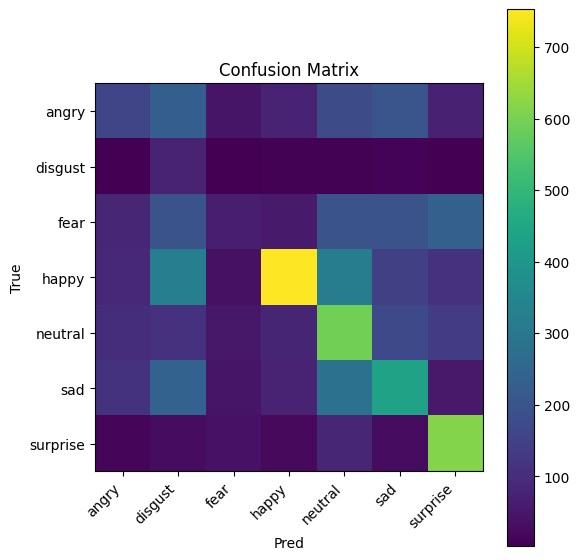

In [9]:
# Strategy B: fine-tune full model (lower LR)
m_b = mk_m(n_cls).to(dev)
unfreeze_all(m_b)
print("Trainable params (B):", n_trainable(m_b))

opt_b = torch.optim.AdamW(m_b.parameters(), lr=lr_b, weight_decay=wd)

scaler = torch.cuda.amp.GradScaler() if dev.type == "cuda" else None

for e in range(ep_b):
    tr_loss = run_ep(m_b, tr_dl, opt_b, loss_fn, is_train=True, scaler=scaler)
    va_loss = run_ep(m_b, va_dl, opt_b, loss_fn, is_train=False, scaler=None)
    met = eval_m(m_b, va_dl)
    print(f"B | ep {e+1}/{ep_b} | tr_loss {tr_loss:.4f} | va_loss {va_loss:.4f} | acc {met['acc']:.4f} | f1 {met['f1_macro']:.4f}")

met_b = eval_m(m_b, va_dl)
print("\nStrategy B metrics:")
print({k: v for k, v in met_b.items() if k not in {"cm", "yt", "yp"}})
show_cm(met_b["cm"], ds_tr.classes)


In [10]:
# Compare Strategy A vs Strategy B
rows = []
for name, met in [("A (layer4+head)", met_a), ("B (full FT)", met_b)]:
    rows.append({
        "strategy": name,
        "acc": met["acc"],
        "p_macro": met["p_macro"],
        "r_macro": met["r_macro"],
        "f1_macro": met["f1_macro"],
    })

cmp = pd.DataFrame(rows)
cmp


,strategy,acc,p_macro,r_macro,f1_macro
0,A (layer4+head),0.545834,0.499095,0.567175,0.497167
1,B (full FT),0.376149,0.359508,0.418299,0.332746
